In [27]:
# Lithium-ion battery aging dataset based on electric vehicle real-driving profiles
# dataset collected from
# https://osf.io/qsabn/?view_only=2a03b6c78ef14922a3e244f3d549de78
# cell: LG 21700 M50T

In [28]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [29]:
# load data
data_dir = 'lg21700m50t_data_mat/'
capacity_test_file = 'capacity_test.mat'
dataset = scipy.io.loadmat(data_dir + capacity_test_file)
print(dataset.keys())

dict_keys(['__header__', '__version__', '__globals__', 'cap', 'col_cell_label', 'curr', 'row_diag_number', 'time', 'vcell'])


In [30]:
# preprocess
cap_arrays = dataset['cap'].flatten()
vcell_arrays = dataset['vcell'].flatten()

# filter out invalid data
valid = np.array([1 if len(cap) > 1 else 0 for cap in cap_arrays]) & np.array([1 if len(vcell) > 1 else 0 for vcell in vcell_arrays])
cap_arrays = cap_arrays[valid == 1]
vcell_arrays = vcell_arrays[valid == 1]
print('valid data:', len(cap_arrays))

valid data: 101


In [31]:
# calculate average ocv-soc curve

num_data = min(len(c) for c in cap_arrays)
v_hi = min(np.max(v) for v in vcell_arrays)
v_lo = max(np.min(v) for v in vcell_arrays)
print(f'num data: {num_data}, max voltage: {v_hi}, min voltage: {v_lo}')

v_range = np.linspace(v_lo, v_hi, num_data).flatten()
interp = lambda x, y: np.interp(-v_range, -x.flatten(), y.flatten())    # negative because numpy expects increasing x
cap_interps = np.array([interp(v, cap) for v, cap in zip(vcell_arrays, cap_arrays)])

cap_mean = np.mean(cap_interps, axis=0)
cap_std = np.std(cap_interps, axis=0)

num data: 66067, max voltage: 4.185150146484375, min voltage: 2.500108480453491


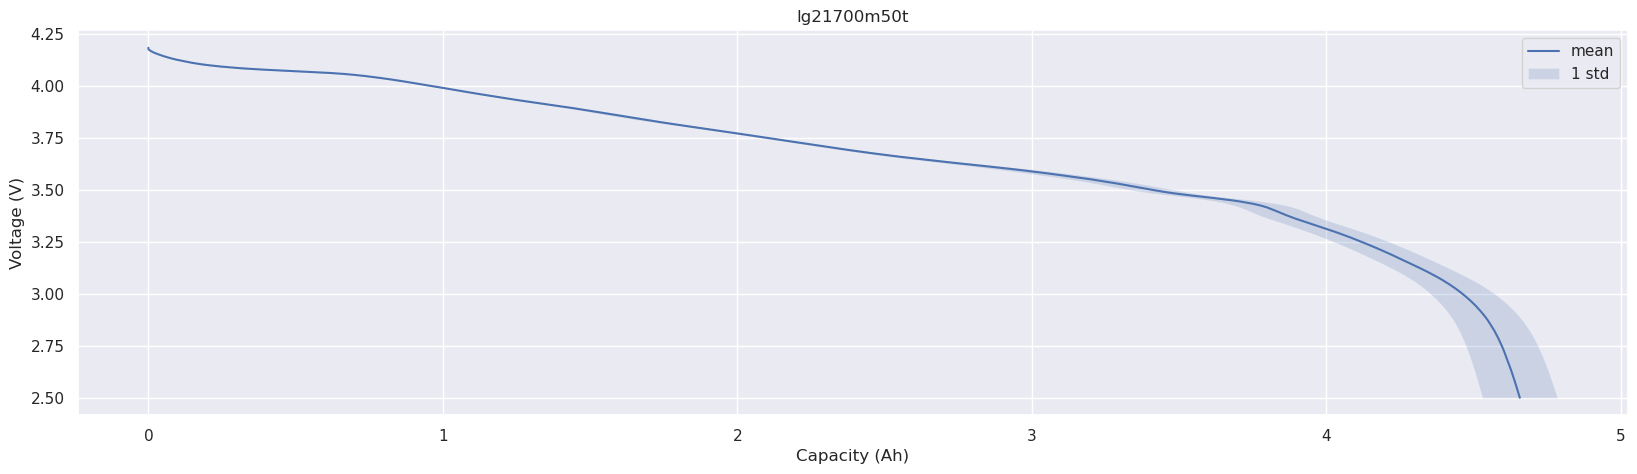

In [32]:
# plot average of capacity curves

plt.figure(figsize=(20, 5))
plt.plot(cap_mean, v_range, label='mean')
plt.fill_betweenx(v_range, cap_mean - cap_std, cap_mean + cap_std, alpha=0.2, label='1 std')
plt.title(data_dir.split('_')[0])
plt.xlabel('Capacity (Ah)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

In [33]:
# linear interpolation with integer lookup table
LUT_SPACING = 5
v_lo_mv = np.rint(v_lo * 1000 / LUT_SPACING).astype(int)
v_hi_mv = np.rint(v_hi * 1000 / LUT_SPACING).astype(int)
lut_size = v_hi_mv - v_lo_mv + 1
print(lut_size)
v_lo_mv = v_lo_mv * LUT_SPACING
v_hi_mv = v_hi_mv * LUT_SPACING
print(f'voltage range: {v_lo_mv} mV to {v_hi_mv} mV')

v_lut_mv = np.linspace(v_lo_mv, v_hi_mv, lut_size).astype(int)
cap_lut_uAh = np.round(np.interp(v_lut_mv, v_range * 10**3, cap_mean * 10**6)).astype(int)

def get_used_capacity(mv):
    
    mv = np.rint(mv).astype(int)
    if mv < v_lo_mv:
        return cap_lut_uAh[0] / 10**6
    elif mv >= v_hi_mv:
        return cap_lut_uAh[-1] / 10**6
    
    # linear interp
    idx_lo = (mv - v_lo_mv) // LUT_SPACING
    weight_lo = mv % LUT_SPACING
    idx_hi = idx_lo + 1
    weight_hi = LUT_SPACING - weight_lo

    cap_uAh = (cap_lut_uAh[idx_lo] * weight_hi + cap_lut_uAh[idx_hi] * weight_lo) // LUT_SPACING
    
    return cap_uAh / 10**6

338
voltage range: 2500 mV to 4185 mV


average error: 0.0006950329010160799 Ah
max error: 0.008363574896682713 Ah


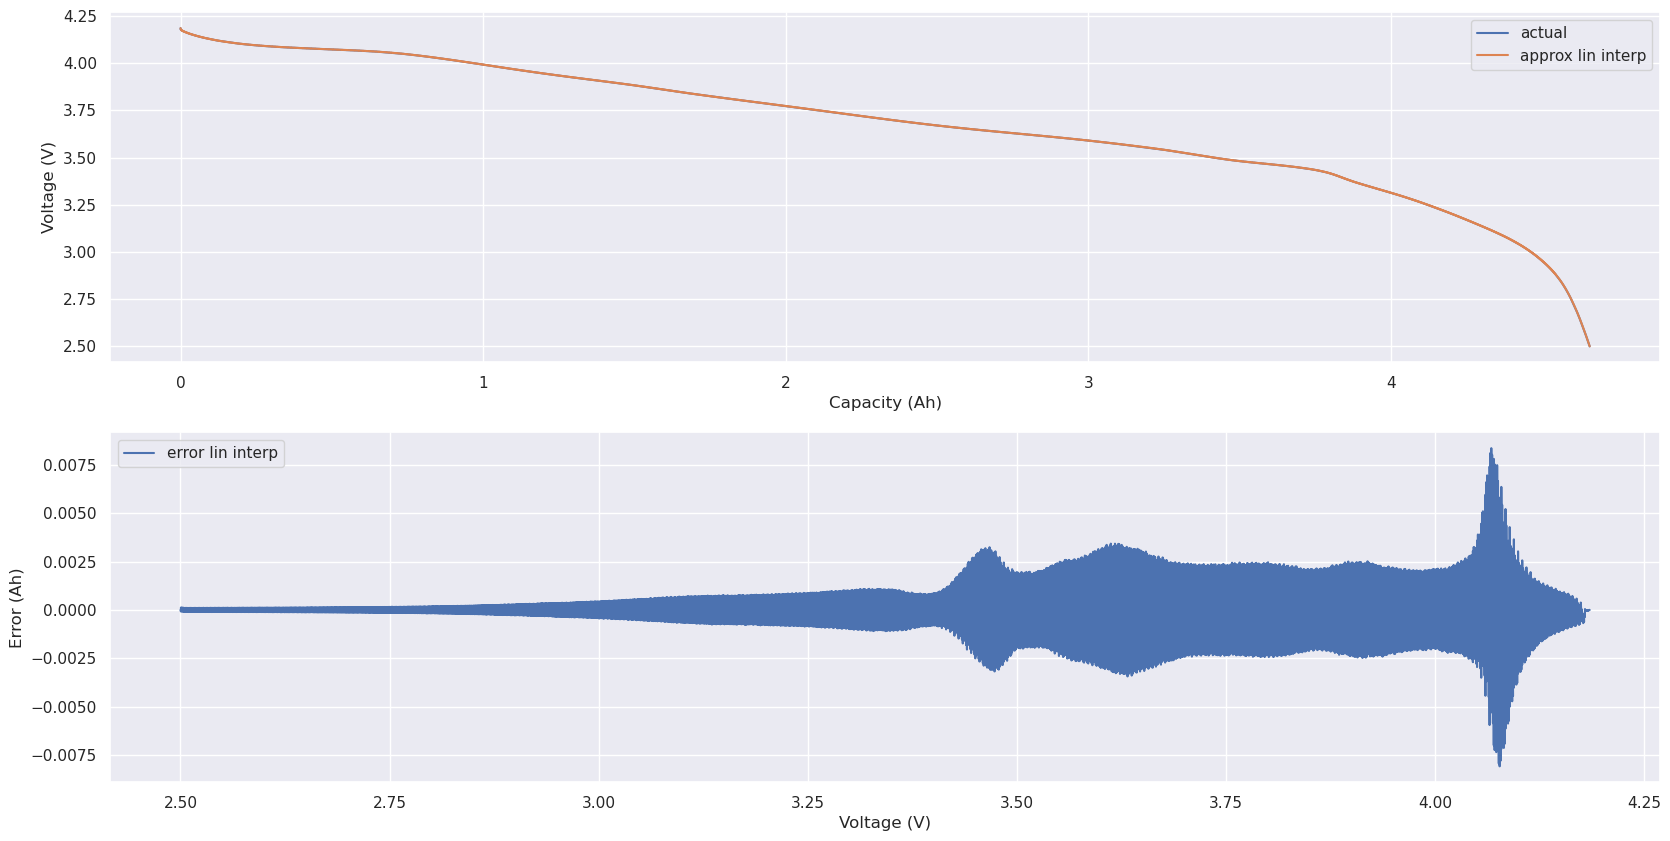

In [34]:
# evaluate
cap_approx = np.array([get_used_capacity(v * 10**3) for v in v_range])
avg_error = np.mean(np.abs(cap_mean - cap_approx))
max_error = np.max(np.abs(cap_mean - cap_approx))
print(f'average error: {avg_error} Ah')
print(f'max error: {max_error} Ah')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(cap_mean, v_range, label='actual')
ax[0].plot(cap_approx, v_range, label='approx lin interp')
ax[0].set_xlabel('Capacity (Ah)')
ax[0].set_ylabel('Voltage (V)')
ax[0].legend()
ax[1].plot(v_range, cap_mean - cap_approx, label='error lin interp')
ax[1].set_xlabel('Voltage (V)')
ax[1].set_ylabel('Error (Ah)')
ax[1].legend()
plt.show()

In [35]:
# export LUT

lut_name = 'lg21700m50t_ocv_soc_lut'
cap_lut_uAh_actual = cap_lut_uAh[0] - cap_lut_uAh   # reverse to make table capacity remaining instead of charge consumed

with open(lut_name + '.out', 'w') as f:
    f.write(f'#define OCV_SOC_LUT_SIZE      {lut_size}\n')
    f.write(f'#define OCV_SOC_LUT_STRIDE    {LUT_SPACING}\n')
    f.write(f'#define OCV_SOC_LUT_MIN_MV    {v_lo_mv}\n')
    f.write(f'#define OCV_SOC_LUT_MAX_MV    {v_hi_mv}\n')
    f.write(f'#define OCV_SOC_TOTAL_CAP_uAh {cap_lut_uAh_actual[-1]}\n')
    f.write('\n')
    f.write(f'const uint32_t {lut_name}_uAh[OCV_SOC_LUT_SIZE] = {{\n')
    f.write(',\n'.join([f'    {c}' for c in cap_lut_uAh_actual]))
    f.write('\n};')